In [1]:
import math

import ccxt
from crypto_data_fetcher.ftx import FtxFetcher
import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
from scipy.stats import ttest_1samp
import seaborn as sns
import talib

from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit

In [3]:
ftx = ccxt.ftx()
fetcher = FtxFetcher(ccxt_client=ftx)

df = fetcher.fetch_ohlcv(
    market='BTC-PERP',
    interval_sec=1 * 60,
)
df = df[df.index < pd.to_datetime('2022-04-01 00:00:00Z')]

display(df)
df.to_pickle('df_ohlcv.pkl')

,op,hi,lo,cl,volume
timestamp,,,,,
2019-07-20 12:35:00+00:00,10564.25,10572.25,10560.5,10567.75,6.365293e+05
2019-07-20 12:36:00+00:00,10570.25,10572.75,10567.0,10569.25,0.000000e+00
2019-07-20 12:37:00+00:00,10569.25,10573.25,10567.0,10570.25,0.000000e+00
2019-07-20 12:38:00+00:00,10570.25,10572.25,10562.5,10567.00,0.000000e+00
2019-07-20 12:39:00+00:00,10567.00,10567.00,10562.5,10564.25,0.000000e+00
...,...,...,...,...,...
2022-03-31 23:55:00+00:00,45528.00,45531.00,45481.0,45514.00,2.129568e+06
2022-03-31 23:56:00+00:00,45514.00,45549.00,45482.0,45525.00,2.630735e+06
2022-03-31 23:57:00+00:00,45525.00,45530.00,45509.0,45509.00,1.085928e+06


trange 99% 0.006202050739848325
trange 99.9% 0.014938539905311394
trange 99.99% 0.03404841893598233


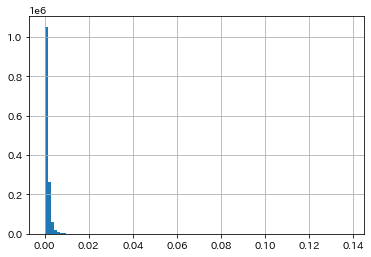

price_band_deviation 99% 0.006315092402021748
price_band_deviation 99.9% 0.015320215083650446
price_band_deviation 99.99% 0.037700373543917275


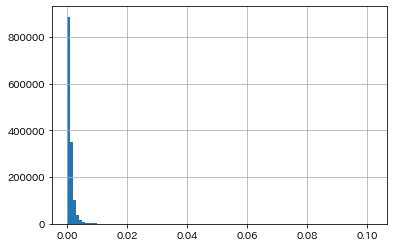

In [9]:
df = pd.read_pickle('df_ohlcv.pkl')

df['trange'] = talib.TRANGE(df['hi'], df['lo'], df['cl']) / df['cl']
df['twap'] = df['cl'].rolling(5).mean()
df['price_band_deviation'] = np.maximum(np.log(df['hi'] / df['twap']), np.log(df['twap'] / df['lo']))

df = df.dropna()

print('trange 99% {}'.format(df['trange'].quantile(0.99)))
print('trange 99.9% {}'.format(df['trange'].quantile(0.999)))
print('trange 99.99% {}'.format(df['trange'].quantile(0.9999)))
df['trange'].hist(bins=100)
plt.show()

print('price_band_deviation 99% {}'.format(df['price_band_deviation'].quantile(0.99)))
print('price_band_deviation 99.9% {}'.format(df['price_band_deviation'].quantile(0.999)))
print('price_band_deviation 99.99% {}'.format(df['price_band_deviation'].quantile(0.9999)))
df['price_band_deviation'].hist(bins=100)
plt.show()